<a href="https://colab.research.google.com/github/manufabregas/Dataset-Asistencia-a-turnos-m-dicos/blob/main/TP%203/VMF_Grupo_2_TP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import pandas as pd
import numpy as np

#Problemática 2:

 Los/as especialistas pierden una cantidad significativa de dinero cuando un paciente no se presenta a su cita. Esto ocurre porque el consultorio ya ha sido alquilado y la agenda para ese día ya está establecida. Por lo tanto, la ausencia del paciente representa una pérdida tanto de tiempo como de ingresos. Si los especialistas pudieran anticipar qué pacientes tienen una alta probabilidad de no asistir, podrían implementar estrategias para mitigar estas pérdidas. Por ejemplo, podrían enviar notificaciones específicas a estos pacientes para confirmar sus citas, o bien ajustar la agenda para incluir turnos de refuerzo (sobreturno) cerca de los horarios de pacientes con alta probabilidad de ausencia. Esta proactividad permitiría optimizar la gestión del tiempo y los recursos, reduciendo así el impacto económico de las ausencias.

# **TEÓRICO**

Todo era perfecto hasta que algo sucedió! Como todo, la vida real presenta sus complejidades y adversidades emergentes, que suelen poner a prueba las desiciones de los científicos de datos. Los siguientes problemas representan situaciones reales por las cuales tuvimos que atravesar y cambiar de perspectiva en un primer momento.

Problema emergente para grupo 2: Nuestro bot, Merlin, ha adquirido un nuevo cliente: el centro médico "Pentos". Este centro presenta una tasa de asistencia notablemente baja, del 61%, en comparación con otros hospitales. El cliente está desesperado por mejorar esta situación y considera que un sistema de notificaciones dirigido a pacientes que podrían no asistir es la solución. La propuesta es enviar un aviso del turno una semana antes, y si el paciente no confirma, el turno se cancelaría automáticamente para permitir la reprogramación con otro paciente. Dada esta situación particular, ¿cómo abordarían la solución para este cliente? ¿Utilizarían el modelo existente para todos los hospitales o desarrollarían un modelo específico para cada uno? ¿Qué diferencias podría implicar esta decisión? Información adicional: El centro médico Pentos lleva operando con Merlin durante 2 meses, por lo que se dispone de datos acumulados en ese periodo (650 registros de turnos médicos).


# 1)Definir el **problema de investigación a realizar**. Si se trata de aprendizaje supervisado deberán elegir si lo abordarán como un problema de **clasificación** o regresión. Explicar qué **motivación** les llevó a elegir esta problemática en particular.

---



**Problema**
El objetivo es predecir la asistencia de pacientes a sus citas médicas en un centro de salud, para optimizar la gestión del personal y recursos del centro. La clínica necesita saber cuántos pacientes asistirán cada día a fin de ajustar la cantidad de personal y recursos necesarios, evitando tanto la sobrecarga como la subutilización.


**Tipo de Aprendizaje:**
Este problema puede abordarse como un problema de clasificación supervisada. La variable objetivo (attendance) será binaria, donde:
* 1: si el paciente asiste a su cita
* 0: si no asiste.

**Motivación:**
Desde nuestro punto de vista, la clave del funcionamiento de un centro médico, radica en la calidad de los especialistas y el buen servicio. Una demora en la atención , puede significar una mala experiencia en el paciente, por lo que gestionar con eficiencia toda la cadena desde que empieza hasta que termina el día es crucial para el éxito.
Esto nos motiva a buscar la mejora continua en la gestión de hospitales, enfocándonos en optimizar la atención de turnos para lograr una mayor eficiencia en los costos y evitar la sobrecarga del personal.

# 2)Seleccionar y preparar las **variables que formarán parte de su modelo**. Si consideran que hay **otra variable a agregar** y no fue construída con anterioridad lo pueden hacer. También variar en la naturaleza de las variables. Por ejemplo, si existe una variable que es continua (alguna tasa de asistencia o edad, etc) es aquí donde la pueden categorizar de la manera que consideren interesante abordar en el modelo.

---



In [117]:
df_base=pd.read_csv("./base_turnos_hospitales.csv")
df_base = df_base[['msp_name','doc_asistance_rate', 'msp_asistance_rate','dni_asistance_rate','age_avg','qt_canc_pac_ac', 'app_days_gap',"attendance",'app_start_dt']]
df_base.head()

,msp_name,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt
0,NEUROLOGIA,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00
1,CARDIOLOGIA INFANTIL,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00
2,NEUROLOGIA,72.831978,71.085359,37.500000,60.0,0.0,33,0,2023-10-10 13:40:00
3,GINECOLOGIA Y OBSTETRICIA,89.130435,86.914721,50.000000,34.0,0.0,1,1,2023-08-23 18:20:00
4,GINECOLOGIA,76.271186,71.529776,100.000000,60.0,0.0,13,1,2023-07-27 16:15:00


In [118]:
#Recordamos la cantidad de filas y columnas
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43140 entries, 0 to 43139
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msp_name            43140 non-null  object 
 1   doc_asistance_rate  43140 non-null  float64
 2   msp_asistance_rate  43140 non-null  float64
 3   dni_asistance_rate  43140 non-null  float64
 4   age_avg             43140 non-null  float64
 5   qt_canc_pac_ac      43140 non-null  float64
 6   app_days_gap        43140 non-null  int64  
 7   attendance          43140 non-null  int64  
 8   app_start_dt        43140 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 3.0+ MB


# **TRANSFORMAMOS LA COL MSP_NAME**

---



In [119]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Agrupamos por msp_name y contamos el total de attendance
df_total_attendance = df_base.groupby('msp_name')['attendance'].sum().reset_index()
df_total_attendance = df_total_attendance.sort_values(by='attendance')

# Agrupamos por msp_name y attendance, contamos las ocurrencias
df_attendance_bars = df_base.groupby(['msp_name', 'attendance']).size().reset_index(name='count')

# Creamos un subplot con un eje secundario
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Gráfico de líneas - Total de Attendance por Especialidad
fig.add_trace(
    go.Scatter(x=df_total_attendance['msp_name'], y=df_total_attendance['attendance'],
               name="Total Attendance", mode='lines+markers'),
    secondary_y=False
)

# Gráfico de barras - Attendance 0 y 1 por Especialidad
for attendance_val in [0, 1]:
    df_filtered = df_attendance_bars[df_attendance_bars['attendance'] == attendance_val]
    fig.add_trace(
        go.Bar(x=df_filtered['msp_name'], y=df_filtered['count'], name=f"Attendance {attendance_val}",
               opacity=0.6),
        secondary_y=True
    )

# Actualizamos los títulos y etiquetas
fig.update_layout(
    title="Total de Attendance por Especialidad (Línea) y Distribución por Attendance (Barras)",
    xaxis_title="Especialidad",
    yaxis_title="Total Attendance (Línea)",
    barmode='group',
    yaxis2_title="Cantidad de Attendance 0/1 (Barras)",
)

fig.update_layout(width=2000, height=800)


# Mostramos el gráfico
fig.show()


In [120]:
pip install category_encoders

# **TRANSFORMAMOS LA COL MSP_NAME PARA HACERLA NUMÉRICA**

---



In [121]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['msp_name'])
df_base['msp_name_encoded'] = encoder.fit_transform(df_base['msp_name'], df_base['attendance'])
df_base.head(2)

,msp_name,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt,msp_name_encoded
0,NEUROLOGIA,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00,0.681788
1,CARDIOLOGIA INFANTIL,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00,0.637736


**OTRA ALTERNATIVA DE ENCODING, PERO CON RESULTADOS SIMILARES:**

In [122]:
# import category_encoders as ce

# encoder = ce.CountEncoder(cols=['msp_name'])
# df_base['msp_name_encoded'] = encoder.fit_transform(df_base['msp_name'])
# df_base.head(2)

In [123]:
#Drop de la col msp_name que ya no nos hace falta
df_base=df_base.drop('msp_name',axis=1)
df_base.head(2)

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt,msp_name_encoded
0,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00,0.681788
1,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00,0.637736


# **Transformamos la Col app_start_dt para convertirla en días de la semana y hora**

In [124]:
# #Creamos la variable turno en base a la hora
# df_base['app_start_dt'] = pd.to_datetime(df_base['app_start_dt'])
# df_base['hora'] = df_base['app_start_dt'].dt.hour
# df_base['turno']=df_base['hora'].apply(lambda x: 'mañana' if 6 <= x < 12 else 'tarde' if 12 <= x < 18 else 'noche')

In [125]:
#Obtenemos el día de la semana -->  (lunes=0, martes=1, ..., domingo=6)
df_base['app_start_dt'] = pd.to_datetime(df_base['app_start_dt'])
df_base['dia_semana_num'] = df_base['app_start_dt'].dt.weekday
df_base.head(3)

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt,msp_name_encoded,dia_semana_num
0,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00,0.681788,4
1,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00,0.637736,1
2,72.831978,71.085359,37.500000,60.0,0.0,33,0,2023-10-10 13:40:00,0.681788,1


# **Transformaremos la col app_days_gap para chequear si obtenemos mejores resultados**

(No mejoró, por eso dejamos comentado el código)

In [126]:
# tertiles = pd.qcut(df_base['app_days_gap'], q=3, labels=["pocos_dias", "moderado", "alto"])
# df_base['distancia_turno'] = tertiles
# df_base.head(3)

In [127]:
# # Aplicamos One Hot Encoding a la columna 'turno'
# df_turno_encoded = pd.get_dummies(df_base[['turno']], prefix=['turno']).astype(int) #,'distancia_turno','gap'

# # Concatenamos las nuevas columnas al dataframe original
# df_base = pd.concat([df_base, df_turno_encoded], axis=1)
# df_base.head(3)

KeyError: "None of [Index(['turno'], dtype='object')] are in the [columns]"

In [128]:
#Drop de la col app_start_dt y turno que ya no nos hacen falta
df_base=df_base.drop(["app_start_dt" ],axis=1) #,'distancia_turno', "turno"
df_base.head(3)

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,msp_name_encoded,dia_semana_num
0,72.831978,71.085359,72.727273,77.0,2.0,39,0,0.681788,4
1,71.698113,75.919732,50.000000,7.0,0.0,48,0,0.637736,1
2,72.831978,71.085359,37.500000,60.0,0.0,33,0,0.681788,1


# **3)Construir el modelo. A continuación se dejan algunas observaciones:**

Seleccionar el **algoritmo que consideren adecuado** para el problema planteado y las **variables elegidas**.
Dividir el conjunto de datos en **entrenamiento y prueba**, y si lo consideran, en validación. Asegurar su **replicabilidad**.
Entrenamiento del modelo.
**Optimización de hiperparámetros**.
En cada punto, justificar brevemente cada elección

---



# **4)Evaluar el modelo.**
Evaluar el rendimiento del modelo a partir de **métricas acordes** a su problema de investigación. Interpretar.
**Realizar validación cruzada**.
Análizar y evaluar **posibles mejoras del modelo frente a errores**. (Explicar por qué se cree que tal algoritmo aplicado no dió los resultados deseados o esperados)
El punto 3 y 4 deberán aplicarse sobre dos algoritmos. La idea es que realicen la construcción y evaluación de dos modelos que consideren, para luego completar la próxima actividad.

---



In [129]:
y = df_base.attendance
X = df_base.drop('attendance',axis=1)

# **ESTANDARIZAMOS LAS COLS**

---



In [130]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

x_names = X.columns
X_scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, columns=x_names)

X

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,msp_name_encoded,dia_semana_num
0,-0.378213,-0.805742,-0.026057,1.761069,0.319952,1.005551,-0.853879,1.466294
1,-0.489198,-0.174922,-0.726693,-1.799023,-0.697647,1.502040,-1.588891,-0.675337
2,-0.378213,-0.805742,-1.112043,0.896475,-0.697647,0.674559,-0.853879,-0.675337
3,1.217113,1.259776,-0.726693,-0.425845,-0.697647,-1.090734,0.974982,0.038540
4,-0.041576,-0.747752,0.814706,0.896475,-0.697647,-0.428749,-0.270524,0.752417
...,...,...,...,...,...,...,...,...
43135,0.468418,0.264849,0.300906,-0.934429,-0.188848,-0.318418,0.974982,0.752417
43136,0.104133,0.907742,-0.212894,0.387891,-0.188848,-0.263253,0.409426,-1.389214
43137,-1.158050,-1.617433,0.814706,0.591325,-0.697647,1.667536,-0.198899,-1.389214
43138,-0.063216,0.178018,-0.726693,-0.934429,-0.697647,-0.925238,-1.141052,-1.389214


In [131]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

Decision Tree
Accuracy train Decision Tree: 0.9965%
Accuracy test Decision Tree: 0.8147%
Precision Decision Tree: 0.8761
Recall Decision Tree: 0.8690
F1-Score Decision Tree: 0.8726
AUC Decision Tree: 0.7688


Gradient Boosting
Accuracy train Gradient Boosting: 0.8644%
Accuracy test Gradient Boosting: 0.8690%
Precision Gradient Boosting: 0.8810
Recall Gradient Boosting: 0.9487
F1-Score Gradient Boosting: 0.9136
AUC Gradient Boosting: 0.9375


Random Forest
Accuracy train Random Forest: 0.9965%
Accuracy test Random Forest: 0.8485%
Precision Random Forest: 0.8785
Recall Random Forest: 0.9197
F1-Score Random Forest: 0.8986
AUC Random Forest: 0.9227


SVM
Accuracy train SVM: 0.8629%
Accuracy test SVM: 0.8623%
Precision SVM: 0.8645
Recall SVM: 0.9622
F1-Score SVM: 0.9107


AUC SVM: 0.9038




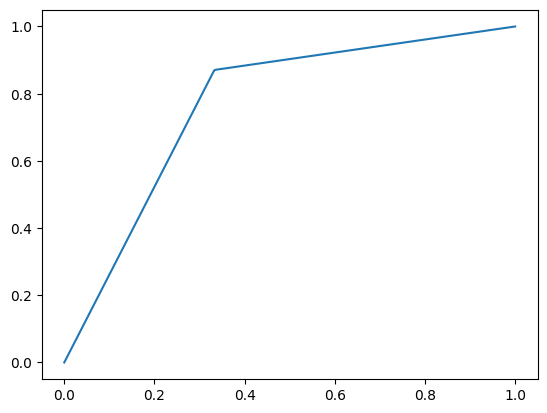

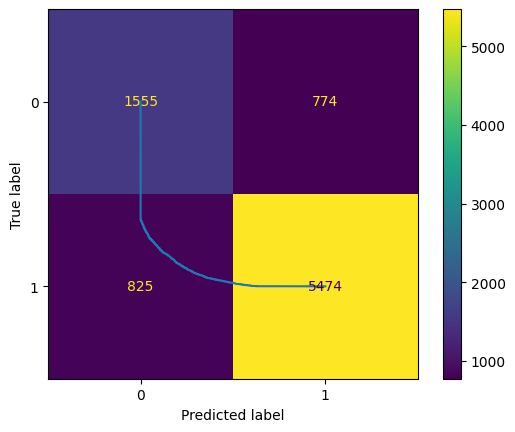

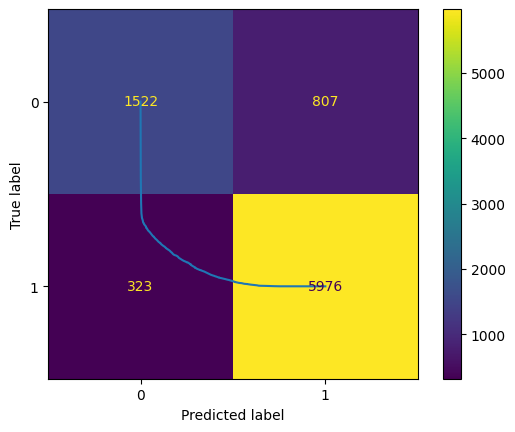

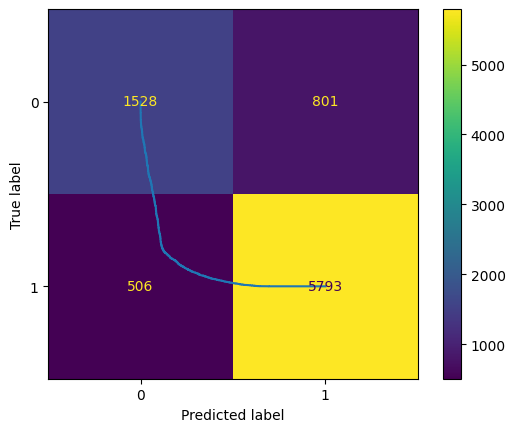

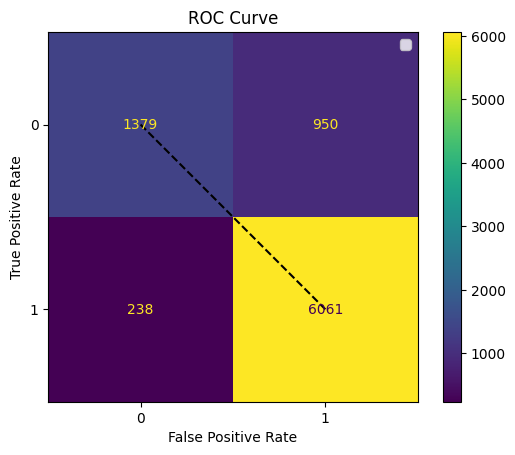

In [133]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)

    # training data
    train_predictions = clf.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: {train_accuracy:.4f}%")

    # test data
    test_predictions = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)

    print(f"Accuracy test {name}: {test_accuracy:.4f}%")
    print(f"Precision {name}: {precision:.4f}")
    print(f"Recall {name}: {recall:.4f}")
    print(f"F1-Score {name}: {f1:.4f}")

    # ROC and AUC
    if hasattr(clf, "predict_proba"):  # If the classifier can predict probabilities
        test_probs = clf.predict_proba(x_test)[:, 1]
    else:
        test_probs = clf.decision_function(x_test)

    fpr, tpr, thresholds = roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)
    print(f"AUC {name}: {roc_auc:.4f}")

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
    print('\n')

    trained_models.append(clf)
    accuracy_models.append(test_accuracy * 100)

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


Decision Tree
Accuracy train Decision Tree: 0.9935%
Accuracy test Decision Tree: 0.8136%
Precision Decision Tree: 0.8758
Recall Decision Tree: 0.8678
F1-Score Decision Tree: 0.8718


Gradient Boosting
Accuracy train Gradient Boosting: 0.8644%
Accuracy test Gradient Boosting: 0.8682%
Precision Gradient Boosting: 0.8805
Recall Gradient Boosting: 0.9482
F1-Score Gradient Boosting: 0.9131


Random Forest
Accuracy train Random Forest: 0.9935%
Accuracy test Random Forest: 0.8459%
Precision Random Forest: 0.8793
Recall Random Forest: 0.9144
F1-Score Random Forest: 0.8965


SVM
Accuracy train SVM: 0.8615%
Accuracy test SVM: 0.8606%
Precision SVM: 0.8625
Recall SVM: 0.9624
F1-Score SVM: 0.9097

# **Análisis Preliminar**

---


###  **Decision Tree y Random Forest**
 Ambos modelos muestran signos de **overfitting**, ya que la precisión en el train es mucho mayor que en el conjunto de test, es decir que no generalizan bien estos modelos. En ambos modelos se podría realizar ajustes de hiperparámetros para reducir el sobreajuste.

###  **Gradient Boosting y SVM**
 Ambos modelos tienen accuraccy similares y son los mejores modelos en términos de generalización, ya que tienen un balance entre en cuanto a rendimiento en entrenamiento y en prueba. Ambos modelos tienen un nivel alto de recall 94.82% y 96.24% respectivamente, lo que significa que son muy buenos modelos detectando la clase positiva (asistencias). En conclusión,  **Gradient Boosting** tiene un mejor F1-Score general y un mejor equilibrio entre precisión y recall. Mientras que **SVM** destaca con el recall más alto y un F1-Score de 0.9097 siendo muy bien balanceado en cuanto a precisión y recall.

# **Hiperámetros para Gradient Boosting y SVM**

---



In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import GradientBoostingClassifier

# gb = GradientBoostingClassifier(random_state=42)

# # param_grid = {
# #     'n_estimators': [100, 200, 300],  # Número de árboles
# #     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje
# #     'max_depth': [3, 5, 7],  # Profundidad máxima del árbol
# #     'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
# #     'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
# #     'subsample': [0.8, 1.0]  # Proporción de datos a usar en cada árbol
# # }

# param_grid = {
#         'n_estimators': [200, 300],
#         'learning_rate': [0.1, 0.05],
#         'max_depth': [3, 4, 5],
#     }

# grid_search = GridSearchCV(estimator=gb, param_grid=param_grid,
#                            scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# grid_search.fit(x_train, y_train)

# print("Best hyperparameters:", grid_search.best_params_)

# best_model = grid_search.best_estimator_
# test_accuracy = best_model.score(x_test, y_test)
# print(f"Test Accuracy of best model: {test_accuracy:.4f}")


* Fitting 5 folds for each of 12 candidates, totalling 60 fits
* Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
* Test Accuracy of best model: 0.8687




In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# svc = SVC(random_state=42)

# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid,
#                            scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# grid_search.fit(x_train, y_train)

# print("Best hyperparameters:", grid_search.best_params_)

# best_model = grid_search.best_estimator_
# test_accuracy = best_model.score(x_test, y_test)
# print(f"Test Accuracy of best model: {test_accuracy:.4f}")

* Fitting 5 folds for each of 12 candidates, totalling 60 fits
* Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
* Test Accuracy of best model: 0.8639

Gradient Boosting
Accuracy train Gradient Boosting: 0.8645%
Accuracy test Gradient Boosting: 0.8687%
Precision Gradient Boosting: 0.8813
Recall Gradient Boosting: 0.9478
F1-Score Gradient Boosting: 0.9133


SVM
Accuracy train SVM: 0.8595%
Accuracy test SVM: 0.8639%
Precision SVM: 0.8773
Recall SVM: 0.9459
F1-Score SVM: 0.9103




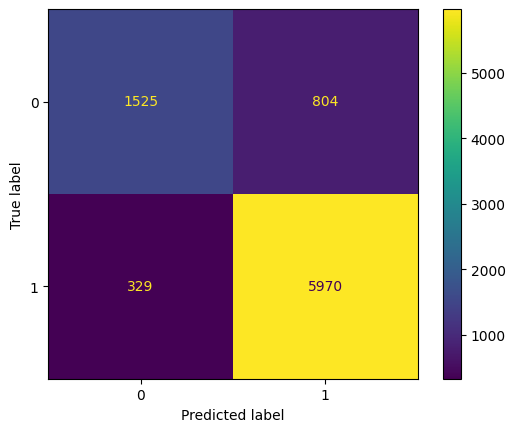

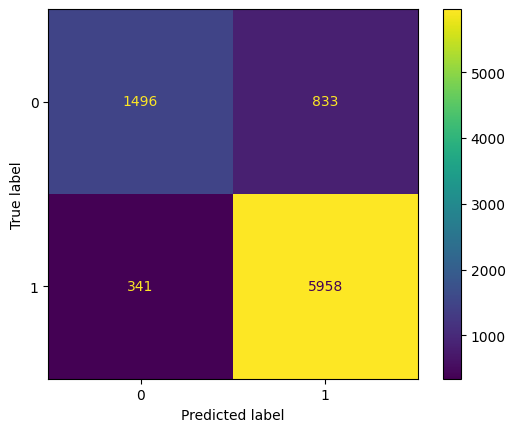

In [ ]:
#Aplicamos random_state=42 para garantizar que los resultados sean siempre los mismos
clfs = [
    GradientBoostingClassifier(random_state=42, learning_rate=0.05, max_depth=3, n_estimators=200),
    SVC(random_state=42, C=1, gamma='scale', kernel='linear')
]


names = [ 'Gradient Boosting', 'SVM']

trained_models = []
accuracy_models = []

trained_models = []
accuracy_models = []

for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)

    # training data
    train_predictions = clf.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: {train_accuracy:.4f}%")

    # test data
    test_predictions = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)

    print(f"Accuracy test {name}: {test_accuracy:.4f}%")
    print(f"Precision {name}: {precision:.4f}")
    print(f"Recall {name}: {recall:.4f}")
    print(f"F1-Score {name}: {f1:.4f}")
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
    print('\n')



    trained_models.append(clf)

# **5)Comparación de modelos. A partir de los dos modelos aplicados se deberá:**
Mencionar las principales caracteristicas (ventajas y desventajas generales) de cada algoritmo.
Fundamentar la elección de cada uno ante el problema de investigación planteado. ¿Por qué lo consideré en primer momento? ¿Por qué este algoritmo en primera instancia era el que mejores resultados podría arrojar para este conjunto de datos?
Comparar los resultados obtenidos con cada modelo a partir de las métricas, así como tiempos y costo computacional que insumieron.
Elegir un modelo final que sería presentado a sus clientes, fundamentando el por qué de su elección.
Si durante el desarrollo de este trabajo utilizan y/o aplican más de dos algoritmos pueden compartir la experiencia o resultados (teóricos) de por qué no fueron incluídos en el informe final. Se espera observar en la entrega solo los procedimientos de 2 de los modelos, nada más.

---



# **Ventajas y Desventajas de los modelos entrenados:**

---


## **1. Gradient Boosting:**
**Ventajas:**

Tiende a ofrecer buenos resultados en conjuntos de datos complejos y por lo que observamos tiene un alto control de sobreajuste, gracias a los hiperparámetros como learning_rate y n_estimators, además de que es un algoritmo que funciona bien en datasets donde las características están correlacionadas.

**Desventajas:**

Se podría mencionar que tiene un costo computacional ya que puede ser lento,  especialmente cuando se ajustan varios hiperparámetros.

## **2. Support Vector Machines (SVM):**
**Ventajas:**

El uso de diferentes kernels, lo cual Ofrece la flexibilidad de utilizar diferentes funciones kernel (lineal, polinómico, RBF), lo que permite adaptar el modelo a diferentes problemas. Además de que es un algoritmo que generaliza bien en conjuntos de datos no vistos, minimizando el sobreajuste.
**Desventajas:**

Al igual que con Gradient Boosting, este algoritmo puede ser lento, especialmente cuando se trabaja con grandes cantidades de datos, ya que implica encontrar un hiperplano óptimo a través de la maximización del margen.


# **Comparación de Resultados Obtenidos:**


---


##**Gradient Boosting:**

* Precisión en entrenamiento: 86.45%
* Precisión en prueba: 86.87%
* Precision: 0.8813
* Recall: 0.9478
* F1-Score: 0.9133



## **SVM:**
* Precisión en entrenamiento: 85.95%
* Precisión en prueba: 86.39%
* Precision: 0.8773
* Recall: 0.9459
* F1-Score: 0.9103

# **Conclusiones**

---
Ambos modelos tienen precisiones similares en el conjunto de prueba (86.87% para **Gradient Boosting** y 86.39% para **SVM**), lo que indica que ambos están generalizando bien. Gradient Boosting tiene un F1-Score ligeramente mejor (0.9133 frente a 0.9103), lo que sugiere que está manejando mejor el balance entre precisión y recall. El mejor modelo que consideramos para predecir es Gradient Boosting, ya que tiene un rendimiento superior, por lo que vemos en las métricas F1-Score y Recall.


**Otras Experiencias con Algoritmos No Incluidos:** Random Forest fue considerado inicialmente, pero el modelo mostró problemas de sobreajuste, ya que la precisión en el entrenamiento era significativamente mayor que en el conjunto de prueba. Esto lo descartó como una opción viable.
Decision Tree también fue probado, pero presentó resultados inconsistentes y un sobreajuste considerable, con una diferencia muy grande entre el entrenamiento y la prueba.

En resumen, **Gradient Boosting** es el modelo que mejor equilibra precisión, recall y generalización para este conjunto de datos, lo que lo hace ideal para ser presentado como la solución final.


# **Descarga del Dataset**

---



In [ ]:
# from google.colab import files

# nombre_archivo = 'entrega_final_turnos_hospitales.csv'
# df_base.to_csv(nombre_archivo, index=False)

# files.download(nombre_archivo)


Se evaluarán los siguientes aspectos:
1- Que se apliquen los conceptos vistos con los profes en el teórico y en el práctico.

2- Que el entregable no sea solo la notebook. El informe debe tener un mensaje claro y debe presentarse en un formato legible para cualquier tipo de stakeholder. Además, se deberá entregar el dataset trabajado.

3- Capacidad de Análisis y justificación. Proactividad en la profundización de los análisis.

4- Criterio para elegir que solución aplicar en cada caso y con qué método implementarla.

5- Calidad y estilo de código.

Deadline tentativo para la entrega 16/09/2024